In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py 
# from sklearn.model_selection import test_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
import copy
from scipy.io import savemat

## Load dataset 
Steps are 
1. Load training data 
2. To use the parallel training, need to use the same length

['data_sgRNN_x', 'data_label_y', 'data_filename']
shape in_2d: (5410, 4891)
org_shape: (5410, 67, 73)
(5410, 67, 73)
shape in_2d: (401, 4891)
org_shape: (401, 67, 73)
Type: X_train=<class 'numpy.ndarray'>, y_train=<class 'numpy.ndarray'>
Shapes: X_train=(5410, 67, 73), y_train=(5410, 5),X_test=(401, 67, 73), y_test=(401, 5)
unq_vals=[[0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]], unq_counts=[ 397  539 1562 1109 1803]
range:min=0.0, max=1.0000000000000002


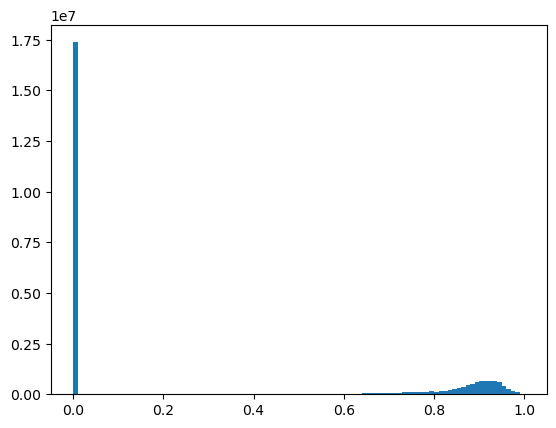

In [2]:
def rs_3d_to_2d(in_3d):
    org_shape = in_3d.shape
    out_2d = np.reshape(in_3d,(org_shape[0],org_shape[1]*org_shape[2]))
    return out_2d

def rs_2d_to_3d(in_2d,org_shape):
    print(f"shape in_2d: {in_2d.shape}")
    print(f"org_shape: {org_shape}")
    out_3d = np.reshape(in_2d,(in_2d.shape[0],org_shape[1],org_shape[2]))
    return out_3d

def rs_minmax_txf(in_3d, minmax_scaler):
    org_shape = in_3d.shape
    out_scaled_3d = rs_2d_to_3d(minmax_scaler.transform(rs_3d_to_2d(in_3d)), org_shape)
    return out_scaled_3d

root_out_dir = '../Datasets/sgRNN_vIHC/PyData/'
train_dataset = np.load(root_out_dir + 'sgRNN_data_train_file.npz', allow_pickle=True)
print(train_dataset.files)

X_trainOrg = train_dataset["data_sgRNN_x"][:] # your train set features
y_train = to_categorical(np.ravel(np.array(train_dataset["data_label_y"][:]))) # your train set labels

train_len_pre = np.array([item.shape[1] for item in X_trainOrg])
max_len = train_len_pre.max()
# Preprocess to make the data the same length 
X_trainOrg = [np.concatenate([item, -(2**7)*np.ones((item.shape[0], max_len-item.shape[1]))],axis=1) for item in X_trainOrg]
train_len_post = np.array([item.shape[1] for item in X_trainOrg])
# X_trainOrg = np.asarray(X_trainOrg, dtype=np.int8)
X_trainOrg = np.asarray(X_trainOrg)

img_shape = X_trainOrg.shape[1:]

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(rs_3d_to_2d(X_trainOrg))
X_train = rs_minmax_txf(X_trainOrg, minmax_scaler)

print(X_train.shape)
plt.hist(np.ndarray.flatten(X_train), 100)

# If we want to train using clean calls only, then take the last 1203 points from the training dataset
X_train_clean = X_train[-1203:,:,:]
y_train_clean = y_train[-1203:,:]

test_dataset = np.load(root_out_dir + 'sgRNN_data_test_snrInf.npz', allow_pickle=True)
print(test_dataset)
X_testOrg = test_dataset["data_sgRNN_x"][:] # your train set features
X_testOrg = [np.concatenate([item, -(2**7)*np.ones((item.shape[0], max_len-item.shape[1]))],axis=1) for item in X_testOrg]
# X_testOrg = np.asarray(X_testOrg, dtype=np.int8)
X_testOrg = np.asarray(X_testOrg)
X_test = rs_minmax_txf(X_testOrg, minmax_scaler)
y_test = to_categorical(np.ravel(np.array(test_dataset["data_label_y"][:]))) # your train set labels

print(f"Type: X_train={type(X_train)}, y_train={type(y_train)}")
print(f"Shapes: X_train={X_train.shape}, y_train={y_train.shape},X_test={X_test.shape}, y_test={y_test.shape}")

unq_vals, unq_counts = np.unique(y_train, axis=0, return_counts=True)
print(f"unq_vals={unq_vals}, unq_counts={unq_counts}")

print(f"range:min={np.amin(X_train)}, max={np.amax(X_train)}")

## Create an CNN to fit using noisy data 

In [3]:
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
CNNmodel_noisy = tf.keras.Sequential([
    ## ZeroPadding2D with padding 3, input shape of 80 x 69 x 1
    ## Conv2D with 32 5x5 filters and stride of 1
    ## BatchNormalization for axis 3
    ## ReLU
    ## Max Pooling 2D with default parameters
    ## Flatten layer
    ## Dense layer with 1 unit for output & 'sigmoid' activation            
        
    tf.keras.layers.ZeroPadding2D(padding=3,input_shape=(67,73,1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5),padding='same', strides=(1,1)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.ReLU(),
    # tf.keras.layers.Dropout(rate=.1),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.ZeroPadding2D(padding=3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5),padding='same', strides=(1,1)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.ReLU(),
    # tf.keras.layers.Dropout(rate=.1),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.ZeroPadding2D(padding=3),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(5,5),padding='same', strides=(1,1)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.ReLU(),
    # tf.keras.layers.Dropout(rate=.1),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=5, activation='softmax'),
    ])

CNNmodel_noisy.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
CNNmodel_noisy.summary()

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_clean, y_train_clean)).batch(32)
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)
history_noisy = CNNmodel_noisy.fit(train_dataset, epochs=100, validation_data=test_dataset)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 73, 79, 1)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 73, 79, 16)        416       
                                                                 
 batch_normalization (BatchN  (None, 73, 79, 16)       64        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 73, 79, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 39, 16)       0         
 )                                                               
                                                        

## Create an CNN to fit using clean data 

In [5]:
tf.random.set_seed(1234)  # applied to achieve consistent results

CNNmodel_clean = tf.keras.Sequential([
    ## ZeroPadding2D with padding 3, input shape of 80 x 69 x 1
    ## Conv2D with 32 5x5 filters and stride of 1
    ## BatchNormalization for axis 3
    ## ReLU
    ## Max Pooling 2D with default parameters
    ## Flatten layer
    ## Dense layer with 1 unit for output & 'sigmoid' activation            
        
    # YOUR CODE STARTS HERE
    tf.keras.layers.ZeroPadding2D(padding=3,input_shape=(67,73,1)),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(5,5),padding='same', strides=(1,1)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.ZeroPadding2D(padding=3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5,5),padding='same', strides=(1,1)),
    tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.ReLU(),
    # tf.keras.layers.Dropout(rate=.1),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(units=5, activation='softmax'),
    # YOUR CODE ENDS HERE
    ])

CNNmodel_clean.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
CNNmodel_clean.summary()

train_dataset_clean = tf.data.Dataset.from_tensor_slices((X_train_clean, y_train_clean)).batch(32)
history_clean = CNNmodel_clean.fit(train_dataset_clean, epochs=50, validation_data=test_dataset)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_4 (ZeroPaddi  (None, 73, 79, 1)        0         
 ng2D)                                                           
                                                                 
 conv2d_4 (Conv2D)           (None, 73, 79, 16)        416       
                                                                 
 batch_normalization_4 (Batc  (None, 73, 79, 16)       64        
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 73, 79, 16)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 39, 16)       0         
 2D)                                                             
                                                      

## Get training fit 

13/13 [==============================] - 0s 3ms/step
Unique values in y_train_pred_NN=[0 1 2 3 4]
Unique values in y_test_pred_NN=[0 1 2 3 4]
Training accuracy=0.9539741219963032
 Testing accuracy=0.9675810473815462



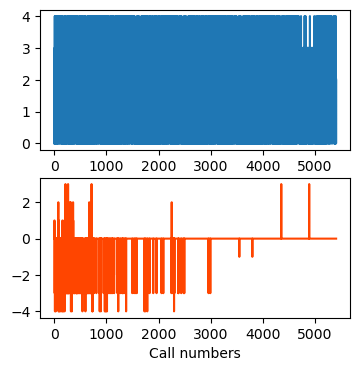

In [6]:
y_train_pred_CNN_clean = np.argmax(CNNmodel_clean.predict(X_train_clean), axis=1)
y_train_true_clean= np.argmax(y_train_clean, axis=1)
train_accuracy_cleanCNN = np.sum(y_train_true_clean==y_train_pred_CNN_clean)/len(y_train_true_clean)

y_train_pred_CNN_noisy = np.argmax(CNNmodel_noisy.predict(X_train), axis=1)
y_test_pred_CNN_noisy = np.argmax(CNNmodel_noisy.predict(X_test), axis=1)
y_train_true_noisy= np.argmax(y_train, axis=1)
y_test_true_noisy = np.argmax(y_test, axis=1)
train_accuracy_noisyCNN = np.sum(y_train_true_noisy==y_train_pred_CNN_noisy)/len(y_train)

print(f"Unique values in y_train_pred_NN={np.unique(y_train_pred_CNN_noisy)}")
print(f"Unique values in y_test_pred_NN={np.unique(y_test_pred_CNN_noisy)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_true_noisy)
ax[1].plot(y_train_true_noisy-y_train_pred_CNN_noisy, color = "orangered")
ax[1].set_xlabel("Call numbers")

print(f"Training accuracy={train_accuracy_noisyCNN}\n Testing accuracy={np.sum(y_test_true_noisy==y_test_pred_CNN_noisy)/len(y_test_true_noisy)}\n")

Test in different SNRs 

../Datasets/sgRNN_vIHC/PyData/sgRNN_data_test_snr-20.npz
shape in_2d: (401, 4891)
org_shape: (401, 67, 73)
13/13 [==============================] - 0s 2ms/step
Testing accuracy: Noisy = 0.3740648379052369, clean = 4

../Datasets/sgRNN_vIHC/PyData/sgRNN_data_test_snr-15.npz
shape in_2d: (401, 4891)
org_shape: (401, 67, 73)
13/13 [==============================] - 0s 2ms/step
Testing accuracy: Noisy = 0.5486284289276808, clean = 4

../Datasets/sgRNN_vIHC/PyData/sgRNN_data_test_snr-10.npz
shape in_2d: (401, 4891)
org_shape: (401, 67, 73)
13/13 [==============================] - 0s 2ms/step
Testing accuracy: Noisy = 0.743142144638404, clean = 4

../Datasets/sgRNN_vIHC/PyData/sgRNN_data_test_snr-5.npz
shape in_2d: (401, 4891)
org_shape: (401, 67, 73)
13/13 [==============================] - 0s 2ms/step
Testing accuracy: Noisy = 0.8403990024937655, clean = 4

../Datasets/sgRNN_vIHC/PyData/sgRNN_data_test_snr0.npz
shape in_2d: (401, 4891)
org_shape: (401, 67, 73)
13/13 [======================

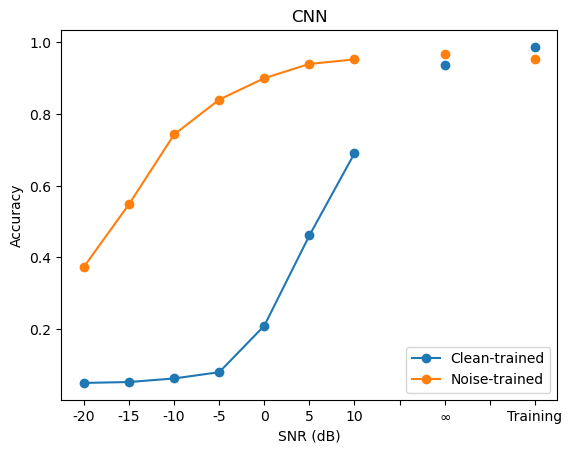

In [9]:
doSaveData = True
all_snrs= np.arange(-20.0, 11, 5)
all_snrs= np.append(all_snrs, np.inf)

test_accuracy_noisyCNN = np.zeros((all_snrs.shape))
test_accuracy_cleanCNN = np.zeros((all_snrs.shape))

for snr_value,iter in zip(all_snrs,range(all_snrs.shape[0])):
    if np.isinf(snr_value):
        out_sgRNN_data_test_file= root_out_dir + 'sgRNN_data_test_snrInf.npz'
    else: 
        out_sgRNN_data_test_file= root_out_dir + 'sgRNN_data_test_snr' + str(np.int_(snr_value)) + '.npz'
    print(out_sgRNN_data_test_file)

    test_dataset = np.load(out_sgRNN_data_test_file, allow_pickle=True)
    print(test_dataset)
    X_test = test_dataset["data_sgRNN_x"][:] # your train set features
    X_test = [np.concatenate([item, -(2**7)*np.ones((item.shape[0], max_len-item.shape[1]))],axis=1) for item in X_test]
    # X_test = np.asarray(X_test, dtype=np.int8)
    X_test = rs_minmax_txf(np.asarray(X_test), minmax_scaler)
    # X_test = np.transpose(X_test, (0, 2, 1))
    y_test_snr = np.ravel(np.array(test_dataset["data_label_y"][:])) # your train set labels
    
    y_test_pred_NN_noisy = np.argmax(CNNmodel_noisy.predict(X_test), axis=1)
    y_test_pred_NN_clean = np.argmax(CNNmodel_clean.predict(X_test), axis=1)
    
    test_accuracy_noisyCNN[iter] = np.sum(y_test_snr==y_test_pred_NN_noisy)/len(y_test_snr)
    test_accuracy_cleanCNN[iter] = np.sum(y_test_snr==y_test_pred_NN_clean)/len(y_test_snr)
    print(f"Testing accuracy: Noisy = {test_accuracy_noisyCNN[iter]}, clean = {y_test_pred_NN_clean[iter]}\n")

# plot_snr= copy.deepcopy(all_snrs)
# plot_snr[np.isinf(plot_snr)] = 15
# plt.plot(plot_snr, test_accuracy_noisyCNN, label="Noise-trained")
# plt.plot(plot_snr, test_accuracy_cleanCNN, label="Clean-trained")
# plt.xlabel("SNR (dB)")
# plt.ylabel("Accuracy")
# plt.title("CNN")
# plt.legend()

plot_snr= copy.deepcopy(all_snrs)
plot_snr[np.isinf(plot_snr)] = 20
plot_snr = np.append(plot_snr[:-1], [15, plot_snr[-1], 25, 30])
plot_snr_label = [str(item.astype('int')) for item in plot_snr[:-4]] + [''] + ['$\infty$'] + [''] + ['Training']
plt_accuracy_clean = np.append(test_accuracy_cleanCNN[:-1], [np.nan, test_accuracy_cleanCNN[-1], np.nan, train_accuracy_cleanCNN])
plt_accuracy_noisy = np.append(test_accuracy_noisyCNN[:-1], [np.nan, test_accuracy_noisyCNN[-1], np.nan, train_accuracy_noisyCNN])

plt.plot(plot_snr, plt_accuracy_clean, 'o-', label="Clean-trained")
plt.plot(plot_snr, plt_accuracy_noisy, 'o-', label="Noise-trained")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("CNN")
plt.legend(loc='lower right')
plt.xticks(ticks=plot_snr, labels=plot_snr_label)

if doSaveData:
    out_sgCNN_classify_file = root_out_dir + 'sgCNN_classify_out'
    np.savez(out_sgCNN_classify_file + '.npz', all_snrs=all_snrs, test_accuracy_noisyRNN=test_accuracy_noisyCNN, test_accuracy_cleanRNN=test_accuracy_cleanCNN)
    # mat_dict= {"all_snrs":all_snrs, "test_accuracy_noisyRNN":test_accuracy_noisyRNN, "test_accuracy_cleanRNN":test_accuracy_cleanRNN}
    mat_dict= {"all_snrs":all_snrs, "train_accuracy_cleanCNN":train_accuracy_cleanCNN, "train_accuracy_noisyCNN":train_accuracy_noisyCNN, \
    "test_accuracy_cleanCNN":test_accuracy_cleanCNN, "test_accuracy_noisyCNN":test_accuracy_noisyCNN}
    savemat(out_sgCNN_classify_file + '.mat', mat_dict)